In [1]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import random
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Prepare Dataset
# load data

# relative path to npz files
path = 'Measurements/batches_multisine_att0.09'
file_name = 'output_batch_%d.npz'

def load_file(path, batch_id):
    """
    Loads in the memory a specific batch located in the given path.

    Returns a numpy NpzFile object with the image frames np array named
    as "frames" and the force measurements named as "frames".
    """
    combined_path = os.path.join(path,file_name %i)
    data = np.load(combined_path)
    return data

In [3]:
# Get dataset statistics for normalization
files_num = 5 # how many files to load
data_frames = []
data_forces = []
for i in range(files_num):
    data = load_file(path, i)
    data_frames.append(data['frames'])
    data_forces.append(data['forces'])
combined_frames = np.concatenate(data_frames, axis=0)
combined_forces = np.concatenate(data_forces, axis=0)
features_train = combined_frames
targets_train = combined_forces[:,2]
frames_mean = np.mean(features_train)
frames_std = np.std(features_train)
forces_z_mean = np.mean(targets_train)
forces_z_std = np.std(targets_train)
print(frames_mean)
print(frames_std)
print(forces_z_mean)
print(forces_z_std)

176.82207961213993
84.00390190596558
-0.0894645429186523
1.6746290939564512


In [4]:
# Dataset statistics hardcoded instead of computing every time:
# frames_mean = 176.82272920181757
# frames_std = 84.00240477900314
# forces_z_mean = -0.09853456038795412
# forces_z_std = 1.7382658357699226

In [5]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_channels, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 9, kernel_size = 5, stride = 1, padding = 2)
        self.pool = nn.MaxPool2d(kernel_size = 4, stride = 4)
        self.conv2 = nn.Conv2d(9, 18, kernel_size = 5, stride = 1, padding = 2)
        
        # RNN
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(18 * 16 * 30, hidden_dim, layer_dim, batch_first=True, dropout = 0.2, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Convolutional layers
        x = self.pool(nn.ELU()(self.conv1(x)))
        x = self.pool(nn.ELU()(self.conv2(x)))
        
        # Reshape for RNN
        x = torch.reshape(x, (1, 200, 18 * 16 * 30))  # Reshape to (batch_size, seq_len, input_size)
        
        # RNN
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        out, hn = self.rnn(x, h0)
        
        # Output layer
        out = self.fc(out) 
        out = torch.reshape(out, (200, 1)) # go back to compare to labels
        return out

In [6]:
# Create RNN
input_channels = 3  # RGB channels
hidden_dim = 200  # hidden layer dimension
layer_dim = 2     # number of hidden layers
output_dim = 1   # output dimension

model = RNNModel(input_channels, hidden_dim, layer_dim, output_dim)
#model.load_state_dict(torch.load('pretrained_rnn_17.pth'))
# Define your loss function
error = nn.MSELoss()

# Define your optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Training
file_size = 1000 # one file contains 1000 samples
num_epochs = 30
files_num = 5 # how many files to load
seq_dim = 200
training_loss_list = []
validation_loss_list = []
validation_index = random.randrange(files_num)
print("output_batch_{}.npz set as validation set".format(validation_index))
val_data = load_file(path, validation_index)
iteration_list = []
accuracy_list = []
batch_size = 200 # should be something that leaves zero reminder when it divides the file_size
last_iter = -(files_num-1) * file_size/batch_size
for epoch in range(num_epochs):
    for i in range(files_num):
        if i != validation_index:
            data = load_file(path, i)
            for i in range(int(file_size/batch_size)):
                model.train()
                # Normalize
                normalized_frames = (data['frames'][i*batch_size:(i+1)*batch_size,:,:,:]-frames_mean)/frames_std
                normalized_forces = (data['forces'][i*batch_size:(i+1)*batch_size,2]-forces_z_mean)/forces_z_std

                # Create tensors
                images = torch.from_numpy(normalized_frames).float()
                labels = torch.from_numpy(normalized_forces).float()
                        
                # print(images.shape)  # Add this line to check the shape of images - Debugging purposes
                images = images.permute(0, 3, 1, 2)
                    
                # Clear gradients
                optimizer.zero_grad()

                # Forward propagation
                outputs = model(images)
                outputs = torch.squeeze(outputs)
                
                # Calculate loss
                loss = error(outputs, labels)
                
                # Backpropagation
                loss.backward()
                
                # Update parameters
                optimizer.step()
                
                # Store training loss and iteration
                loss_rescaled = loss.data.item() * pow(forces_z_std, 2)
                training_loss_list.append(loss_rescaled)
    # Print Loss
    print('Epoch: {}, Training Loss (MSE): {}'.format((epoch+1), np.mean(training_loss_list[int(last_iter):])))

output_batch_3.npz set as validation set
Epoch: 1, Training Loss (MSE): 2.66137059249222
Epoch: 2, Training Loss (MSE): 1.5653389893835872
Epoch: 3, Training Loss (MSE): 1.2294508730784173
Epoch: 4, Training Loss (MSE): 1.0339453417863167
Epoch: 5, Training Loss (MSE): 0.8556340665148421
Epoch: 6, Training Loss (MSE): 0.6793830360647658
Epoch: 7, Training Loss (MSE): 0.5578271676571672
Epoch: 8, Training Loss (MSE): 0.495652028341957
Epoch: 9, Training Loss (MSE): 0.3992709355212218
Epoch: 10, Training Loss (MSE): 0.31814482707161357
Epoch: 11, Training Loss (MSE): 0.2483432003244621
Epoch: 12, Training Loss (MSE): 0.23232829025699986
Epoch: 13, Training Loss (MSE): 0.22697194190570139
Epoch: 14, Training Loss (MSE): 0.2115004141935215
Epoch: 15, Training Loss (MSE): 0.15945056210764544
Epoch: 16, Training Loss (MSE): 0.13445281956453187
Epoch: 17, Training Loss (MSE): 0.11847687380075514
Epoch: 18, Training Loss (MSE): 0.10897675696851081
Epoch: 19, Training Loss (MSE): 0.110241723496

[0.9535800237949996, 1.0059670784572925, 4.495809557645446, 3.847594818895453, 4.488165929069695, 4.323058336621548, 3.3519872107450928, 3.3184684418555523, 0.9631828670868182, 0.7734608115186857, 0.6339472059714438, 0.5894446491286394, 4.484582811020584, 4.13911145965935, 5.791236109772474, 2.341936554477584, 2.4607190239489234, 2.1784438390341236, 2.1795306758299495, 0.907184445310742, 0.9313196772566836, 0.8333892799458019, 2.724267586299901, 2.356653982863017, 3.0628297847668446, 2.79534724764045, 1.9158022555287555, 1.7505206555284007, 0.384317910563256, 0.42225243450424743, 0.3761125602015362, 0.4067679771512894, 2.3979484321690805, 2.3080898289910867, 4.079260550794409, 1.1119304901199745, 1.0826967198863855, 1.0385295580037202, 1.0019093259754295, 0.32683352948147476, 0.5369156387375161, 0.5009165936120997, 1.673051356636753, 1.4466640209756614, 1.9773325629307101, 1.8823224335745312, 1.2718554657033747, 1.0927282301980281, 0.5874418489474048, 0.5194121672431273, 0.347932467543

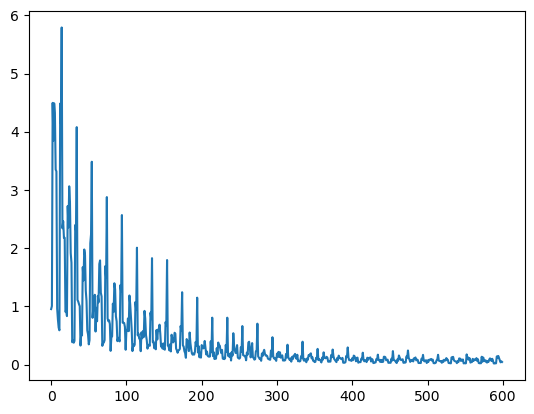

In [8]:
print(training_loss_list)
print(np.sqrt(np.mean(training_loss_list[-25:])))
plt.plot(range(len(training_loss_list)), training_loss_list)
#plt.xlim((0,25)) # modify 
plt.show()

In [9]:
print(outputs * forces_z_std + forces_z_mean) # Small sanity check

tensor([ 0.4708,  0.8327,  0.7649,  0.7288,  0.6741,  0.7415,  0.7572,  0.6837,
         0.7444,  0.8102,  0.8036,  0.7558,  0.7121,  0.8547,  0.8779,  0.8732,
         0.7466,  0.7486,  0.6577,  0.5894,  0.8258,  0.7219,  0.5075,  0.7571,
         0.7865,  0.7643,  0.8666,  0.7156,  0.8144,  0.8383,  0.7745,  0.7629,
         0.7826,  0.8283,  0.6328,  0.7098,  0.7252,  0.7740,  0.6295,  0.7408,
         0.7682,  0.8007,  0.6866,  0.7551,  0.8580,  0.6902,  0.7356,  0.6910,
         0.7375,  0.5638,  0.7214,  0.7026,  0.6695,  0.8175,  0.7144,  0.7542,
         0.7604,  0.0079, -0.4987, -0.3519,  0.5165,  0.8407,  0.7662,  0.6328,
         0.7211,  0.7754,  0.8810,  0.6432,  0.7258,  0.8448,  0.8251,  0.8155,
         0.5909,  0.7146,  0.9617,  0.7779,  0.6991,  0.7376,  0.6569,  0.8064,
         0.8099, -0.8316, -3.1390, -3.8512, -3.5694, -2.7111, -1.4832,  0.0750,
         0.7359,  0.8963,  0.7682,  0.9663,  0.7549,  0.7823,  0.6998,  0.5776,
         0.6456,  0.7055,  0.7049,  0.75

In [10]:
print(labels.float() * forces_z_std + forces_z_mean)

tensor([ 0.6099,  0.6026,  0.6042,  0.6052,  0.6043,  0.5947,  0.6042,  0.6069,
         0.6011,  0.6050,  0.5963,  0.5968,  0.6011,  0.5944,  0.6028,  0.6087,
         0.5988,  0.6047,  0.6036,  0.6003,  0.6064,  0.5989,  0.6045,  0.6018,
         0.6009,  0.6057,  0.6011,  0.6053,  0.6040,  0.6075,  0.6012,  0.6088,
         0.6136,  0.6075,  0.6101,  0.6044,  0.6049,  0.6002,  0.6034,  0.6026,
         0.6030,  0.6058,  0.6073,  0.6076,  0.6014,  0.6017,  0.5991,  0.6021,
         0.6016,  0.6013,  0.6016,  0.6045,  0.6015,  0.6059,  0.6030,  0.6044,
         0.3891, -0.5767, -0.8479, -0.6253, -0.0282,  0.5939,  0.6115,  0.6130,
         0.6125,  0.6068,  0.5993,  0.6039,  0.5975,  0.5972,  0.5953,  0.5979,
         0.6001,  0.5999,  0.6005,  0.5968,  0.6025,  0.6023,  0.6052,  0.6025,
         0.6019, -1.3028, -3.2476, -4.0939, -3.9194, -3.0532, -1.7658, -0.1200,
         0.6131,  0.6063,  0.6020,  0.5966,  0.5970,  0.6070,  0.6053,  0.6017,
         0.6006,  0.6049,  0.6030,  0.51

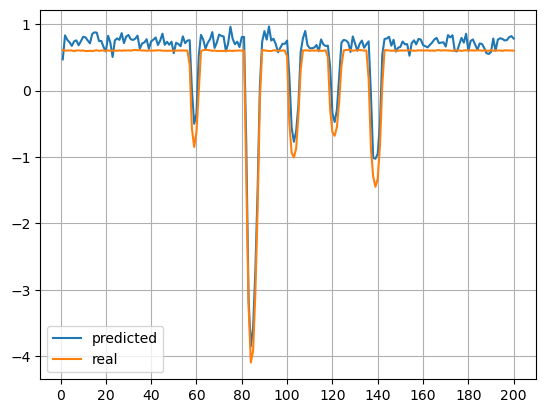

In [11]:
pred_forcess = outputs * forces_z_std + forces_z_mean
forcess = labels.float() * forces_z_std + forces_z_mean
pred_forcess = pred_forcess.detach().numpy()
forcess = forcess.detach().numpy()
plt.plot(range(1,len(pred_forcess)+1), pred_forcess, label = "predicted")
plt.plot(range(1,len(forcess)+1), forcess, label = "real")
plt.xticks([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
plt.grid()
plt.legend()
plt.show()

In [12]:
# Validating


In [13]:
# Testing
#model.eval()

In [14]:
torch.save(model.state_dict(), 'multisine_att0.09_30epoch.pth')